
# Sprint 2 - Entendimiento y preparacion de los datos (Car Evaluation)
Dataset del UCI ML Repository (car evaluation). Objetivo: predecir la clase de aceptabilidad del auto (`unacc`, `acc`, `good`, `vgood`).


In [26]:

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import joblib

sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (8, 4)



## Carga del dataset
- Columnas segun la documentacion: buying, maint, doors, persons, lug_boot, safety, class.
- No hay encabezados en el archivo original.


In [27]:
col_names = ["buying", "maint", "doors", "persons", "lug_boot", "safety", "class"]
df = pd.read_csv("car+evaluation/car.data", names=col_names)
print(df.head())
print("\nShape:", df.shape)

  buying  maint doors persons lug_boot safety  class
0  vhigh  vhigh     2       2    small    low  unacc
1  vhigh  vhigh     2       2    small    med  unacc
2  vhigh  vhigh     2       2    small   high  unacc
3  vhigh  vhigh     2       2      med    low  unacc
4  vhigh  vhigh     2       2      med    med  unacc

Shape: (1728, 7)



## Chequeos basicos
- Tipos de datos, valores unicos por columna y ausencia de nulos (el dataset viene limpio).


In [28]:
print("Tipos:\n", df.dtypes)
print("\nValores nulos por columna:\n", df.isnull().sum())
print("\nCardinalidad por columna:\n", df.nunique())

Tipos:
 buying      object
maint       object
doors       object
persons     object
lug_boot    object
safety      object
class       object
dtype: object

Valores nulos por columna:
 buying      0
maint       0
doors       0
persons     0
lug_boot    0
safety      0
class       0
dtype: int64

Cardinalidad por columna:
 buying      4
maint       4
doors       4
persons     3
lug_boot    3
safety      3
class       4
dtype: int64



## Distribuciones de la variable objetivo y features


In [29]:
print("Distribucion de la clase:\n", df["class"].value_counts())

Distribucion de la clase:
 class
unacc    1210
acc       384
good       69
vgood      65
Name: count, dtype: int64


C:\Users\sebas\AppData\Roaming\Python\Python314\site-packages\seaborn\_base.py:1447: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self.plot_data[axis] = cat_data
C:\Users\sebas\AppData\Roaming\Python\Python314\site-packages\seaborn\categori

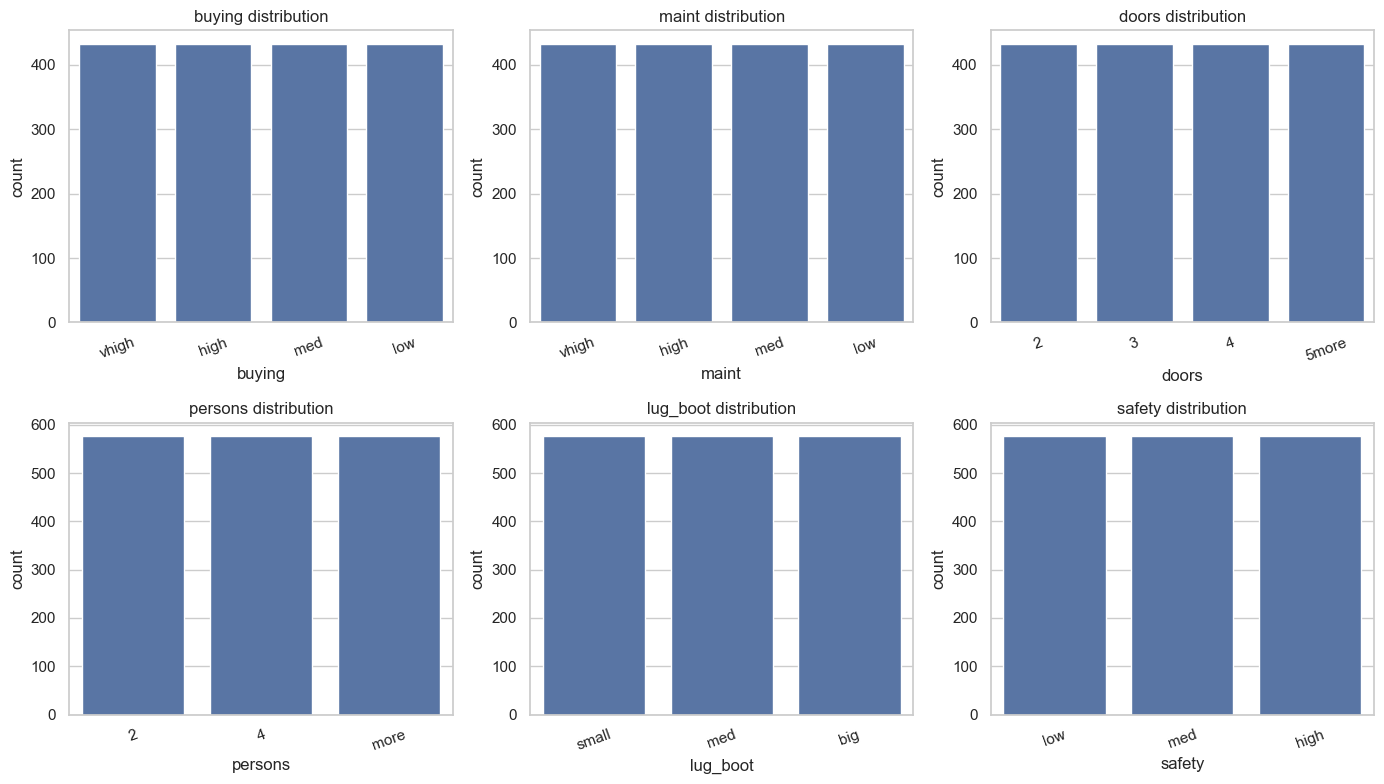

In [30]:

feature_cols = ["buying", "maint", "doors", "persons", "lug_boot", "safety"]
order_map = {
    "buying": ["vhigh", "high", "med", "low"],
    "maint": ["vhigh", "high", "med", "low"],
    "doors": ["2", "3", "4", "5more"],
    "persons": ["2", "4", "more"],
    "lug_boot": ["small", "med", "big"],
    "safety": ["low", "med", "high"],
}

fig, axes = plt.subplots(2, 3, figsize=(14, 8))
for ax, col in zip(axes.flatten(), feature_cols):
    sns.countplot(data=df, x=col, order=order_map[col], ax=ax, color="#4C72B0")
    ax.set_title(f"{col} distribution")
    ax.tick_params(axis="x", rotation=20)
plt.tight_layout()
plt.show()



## Relacion feature-objetivo (ejemplo: safety vs class)


In [31]:

safety_vs_class = pd.crosstab(df["safety"], df["class"], normalize="index").round(3)
print(safety_vs_class)


class     acc   good  unacc  vgood
safety                            
high    0.354  0.052  0.481  0.113
low     0.000  0.000  1.000  0.000
med     0.312  0.068  0.620  0.000



## Preparacion: split train/test y codificacion one-hot
- Todas las variables son categoricas; se usa OneHotEncoder.
- Split estratificado para mantener proporcion de clases.


In [32]:

X = df[feature_cols]
y = df["class"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

preprocess = ColumnTransformer(
    transformers=[
        ("onehot", OneHotEncoder(handle_unknown="ignore"), feature_cols)
    ],
    remainder="drop",
)



## Modelos base y validacion cruzada
- Modelos: Regresion Logistica, Decision Tree, KNN.
- Validacion cruzada 5-fold sobre el set de entrenamiento.


In [33]:

models = {
    "log_reg": LogisticRegression(max_iter=1000, multi_class="auto"),
    "decision_tree": DecisionTreeClassifier(random_state=42),
    "knn": KNeighborsClassifier(n_neighbors=5),
}

results = []
for name, model in models.items():
    pipe = Pipeline([
        ("prep", preprocess),
        ("model", model),
    ])
    cv_scores = cross_val_score(pipe, X_train, y_train, cv=5, scoring="accuracy")
    results.append({
        "model": name,
        "cv_mean": cv_scores.mean(),
        "cv_std": cv_scores.std(),
    })

cv_df = pd.DataFrame(results).sort_values(by="cv_mean", ascending=False)
cv_df


C:\Users\sebas\AppData\Roaming\Python\Python314\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\sebas\AppData\Roaming\Python\Python314\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\sebas\AppData\Roaming\Python\Python314\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\sebas\AppData\Roaming\Python\Python314\site-packages\sklearn\linear_mo

,model,cv_mean,cv_std
1,decision_tree,0.964535,0.007417
0,log_reg,0.899424,0.015057
2,knn,0.883503,0.010065



## Entrenamiento final y evaluacion en test
- Se toma el modelo con mejor promedio de cross-val.
- Se evalua en el holdout (20%).


In [34]:
best_name = cv_df.iloc[0]["model"]
best_model = models[best_name]

best_pipe = Pipeline([
    ("prep", preprocess),
    ("model", best_model),
])

best_pipe.fit(X_train, y_train)
y_pred = best_pipe.predict(X_test)

acc = accuracy_score(y_test, y_pred)
print(f"Mejor modelo: {best_name}")
print(f"Accuracy en test: {acc:.4f}\n")
print("Classification report:\n", classification_report(y_test, y_pred))

cm = pd.crosstab(y_test, y_pred, rownames=["actual"], colnames=["pred"])
print("Confusion matrix (counts):\n", cm)

Mejor modelo: decision_tree
Accuracy en test: 0.9740

Classification report:
               precision    recall  f1-score   support

         acc       0.96      0.92      0.94        77
        good       0.88      1.00      0.93        14
       unacc       0.98      1.00      0.99       242
       vgood       1.00      0.85      0.92        13

    accuracy                           0.97       346
   macro avg       0.95      0.94      0.95       346
weighted avg       0.97      0.97      0.97       346

Confusion matrix (counts):
 pred    acc  good  unacc  vgood
actual                         
acc      71     2      4      0
good      0    14      0      0
unacc     1     0    241      0
vgood     2     0      0     11



## Persistencia del modelo
Se guarda el pipeline completo (preprocesamiento + modelo) para reutilizarlo en el despliegue.


In [35]:

joblib.dump(best_pipe, "best_car_model.pkl")


['best_car_model.pkl']


## Hallazgos rapidos
- No hay nulos; todas las columnas son categoricas con baja cardinalidad.
- `safety` separa fuertemente la clase: cuando es `low` domina `unacc`; `high` concentra `good/vgood`.
- Modelos simples con one-hot logran alta accuracy; revisar matriz de confusion para clases minoritarias.
